In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from card_detector import CardDetector, fit
from dataloader_utils import MTGCardsDataset, get_transform_pipe
from config import *

In [2]:
anchor_boxes = torch.Tensor([[198.27963804, 206.74086672],
       [129.59395666, 161.90171490],
       [161.65437828, 232.34624509]
]) # Anchor boxes acquired from k-means clustering of the dataset

model = CardDetector(
  img_dims= (CONFIG["dataset"]["img_w"], CONFIG["dataset"]["img_h"]),
  anchor_boxes=anchor_boxes,
  num_anchors_per_cell=CONFIG["dataset"]["num_anchors_per_cell"],
)

feature_map_dims = (model.features_w, model.features_h)

transform_pipe = get_transform_pipe(img_w=CONFIG["dataset"]["img_w"], img_h=CONFIG["dataset"]["img_h"])

train_dataset = MTGCardsDataset(
  annotations_file=CONFIG["dataset"]["annotations_file_train"],
  img_dir=CONFIG["dataset"]["img_dir"], #TODO: change directory when we have the actual data
  anchor_boxes=model.anchor_boxes,
  feature_map_dims=feature_map_dims,
  img_dims= (CONFIG["dataset"]["img_w"], CONFIG["dataset"]["img_h"]),
  num_anchors_per_cell=CONFIG["dataset"]["num_anchors_per_cell"],
  num_max_boxes=1,
  transform=transform_pipe,
  limit=CONFIG["dataset"]["limit"]
)
train_dataloader = DataLoader(train_dataset, batch_size=CONFIG["dataloader"]["batch_size"])

val_dataset = MTGCardsDataset(
  annotations_file=CONFIG["dataset"]["annotations_file_val"],
  img_dir=CONFIG["dataset"]["img_dir"], #TODO: change directory when we have the actual data
  anchor_boxes=model.anchor_boxes,
  feature_map_dims=feature_map_dims,
  img_dims= (CONFIG["dataset"]["img_w"], CONFIG["dataset"]["img_h"]),
  num_anchors_per_cell=CONFIG["dataset"]["num_anchors_per_cell"],
  num_max_boxes=1,
  transform=transform_pipe,
  limit=CONFIG["dataset"]["limit"]
)
val_dataloader = DataLoader(val_dataset, batch_size=CONFIG["dataloader"]["batch_size"]) 

In [3]:
opt = torch.optim.Adam(params=model.parameters(), lr=CONFIG["optimizer"]["lr"])
fit(
    model=model,
    num_epochs=CONFIG["optimizer"]["num_epochs"],
    optimizer=opt, 
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=("cuda" if torch.cuda.is_available() else "cpu")
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0



c:\Users\vikio\anaconda3\envs\nsiete_pytorch_project\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Looked at 0 Batches	---	0/1000 Samples
Looked at 31 Batches	---	1000/1000 Samples
Train loss: 0.1899065951583907 | Val Loss: 0.03838512673974037 | Val Accuracy: 0.0
Epoch: 1

Looked at 0 Batches	---	0/1000 Samples
Looked at 31 Batches	---	1000/1000 Samples
Train loss: 0.02532569965114817 | Val Loss: 0.01872684806585312 | Val Accuracy: 0.0
Epoch: 2

Looked at 0 Batches	---	0/1000 Samples
Looked at 31 Batches	---	1000/1000 Samples
Train loss: 0.016367778385756537 | Val Loss: 0.013962156139314175 | Val Accuracy: 0.0
Epoch: 3

Looked at 0 Batches	---	0/1000 Samples
Looked at 31 Batches	---	1000/1000 Samples
Train loss: 0.013036496937274933 | Val Loss: 0.011561735533177853 | Val Accuracy: 0.0
Epoch: 4

Looked at 0 Batches	---	0/1000 Samples
Looked at 31 Batches	---	1000/1000 Samples
Train loss: 0.0111572869354859 | Val Loss: 0.010091779753565788 | Val Accuracy: 0.0
Epoch: 5

Looked at 0 Batches	---	0/1000 Samples
Looked at 31 Batches	---	1000/1000 Samples
Train loss: 0.00995292971492745 | V

tensor([[195.1998, 334.4483, 319.7203, 501.9059]], grad_fn=<SqueezeBackward1>)
tensor([[395., 205., 490., 333.]])


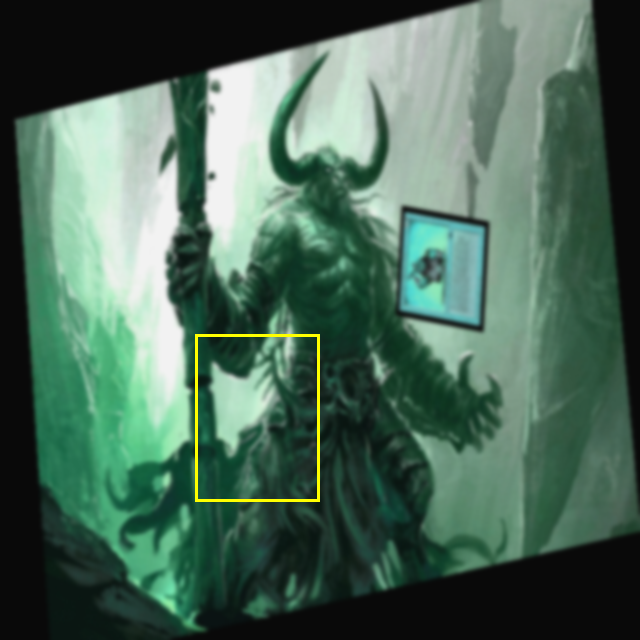

In [10]:
import torchvision.transforms.functional as fn
from torchvision.io import read_image, ImageReadMode
from torchvision.utils import draw_bounding_boxes


images, labels = next(iter(val_dataloader))

# Load the unaltered (not normalized) version of the image
test_image = read_image("data/aug_val/1060_2.png", mode=ImageReadMode.RGB)

# Predict the bounding box and get the true box
model = model.to("cpu")
pred_box = model.predict(images[1]).squeeze(0)
true_box = model.predict(images[1], ground_truth=labels[1].unsqueeze(0)).squeeze(0)

print(pred_box)
print(true_box)

bbox_img_tensor = draw_bounding_boxes(image=test_image, boxes=pred_box, width=3, colors=(255,255,0))

fn.to_pil_image(bbox_img_tensor)

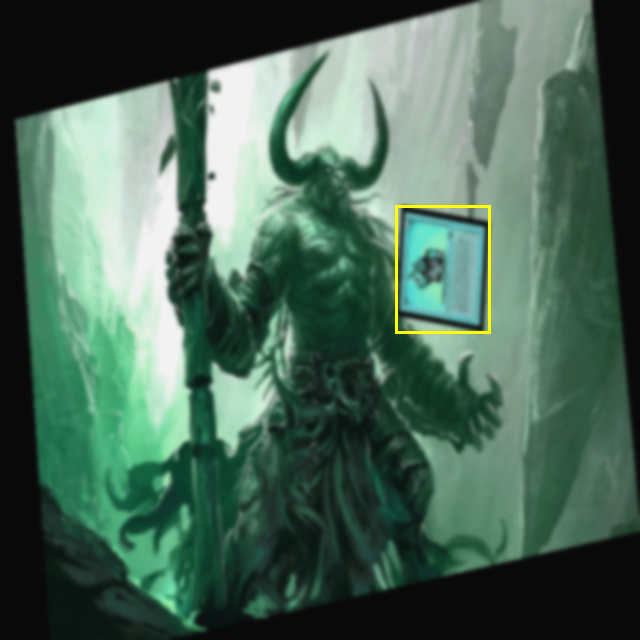

In [11]:
bbox_img_tensor = draw_bounding_boxes(image=test_image, boxes=true_box, width=3, colors=(255,255,0))

fn.to_pil_image(bbox_img_tensor)

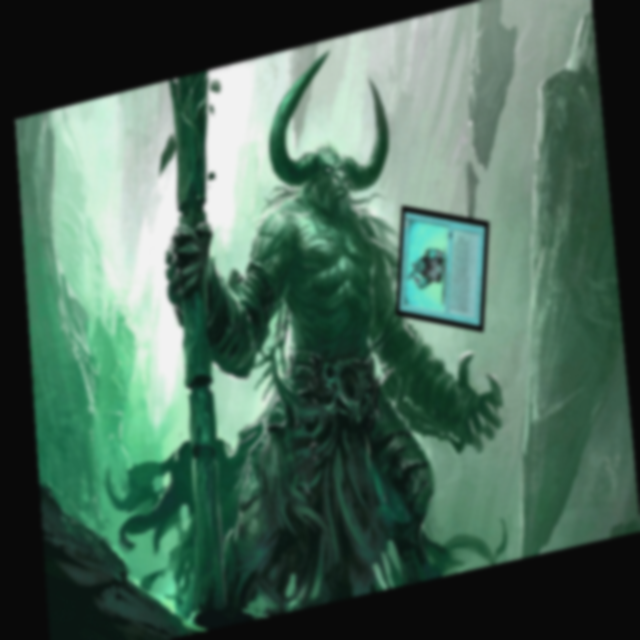

In [12]:
fn.to_pil_image(images[1])

In [6]:
test_image.shape

torch.Size([3, 640, 640])

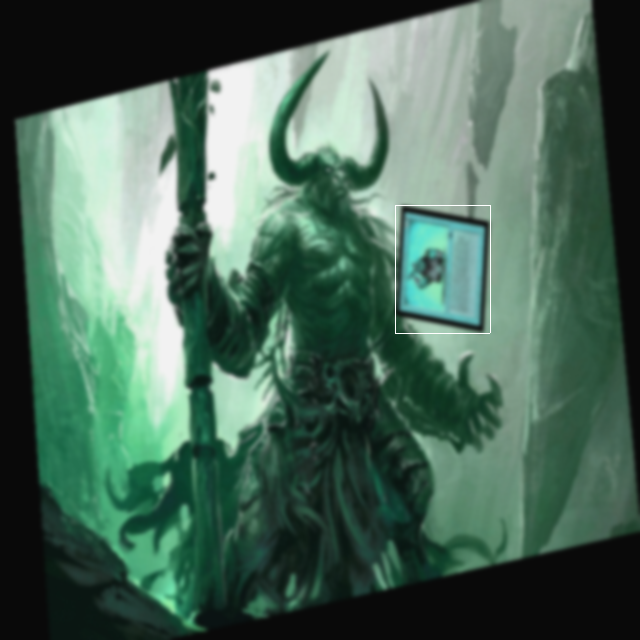

In [15]:
import numpy as np
import torchvision.transforms as transforms

test_array = np.array(test_image).transpose(1, 2, 0)
position = [442.5,269.0,95,128]
offsetx = int(position[0] - position[2]/2)
offsety = int(position[1] - position[3]/2)
width = position[2]
height = position[3]

test_array[offsety:offsety + height, offsetx:offsetx+1] = 255
test_array[offsety:offsety + height, offsetx + width:offsetx + width + 1] = 255

test_array[offsety:offsety + 1, offsetx:offsetx + width] = 255
test_array[offsety + height:offsety + height + 1, offsetx:offsetx + width] = 255

test_bg = transforms.ToPILImage()(test_array)
test_bg